# _In-Silico_ Solvent Optimization Study

This is a test problem to compare how optimization with black-box algorithms does vs. with molecular descriptors.

You should describe the kinetic model used to generate experimental data and the nature of the pareto front.

In [1]:
%load_ext autoreload
%autoreload 2

In [52]:
from surrogate_model_functions import plot_3d_model, loo_error
from solvent_optimization import descriptors_optimization, experiment, create_pcs_ds, pareto_coverage
from summit.strategies import _pareto_front
import numpy as np
import matplotlib.pyplot as plt

In [5]:
#Solvent Dataset compressed to 3 principal components
solvent_ds_pcs = create_pcs_ds(num_components=3)

80 solvents for optimization
68.0% of variance is explained by 3 principal components.


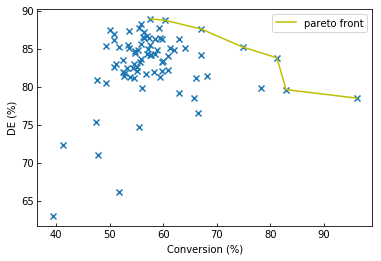

In [53]:
#Visualize all potential experiments
random_state = np.random.RandomState(1000)
all_experiments = [experiment(cas, solvent_ds_pcs, random_state) 
                   for cas in solvent_ds_pcs.index.values]
all_experiments = np.array(all_experiments)
pareto, pareto_indices = pareto_front(all_experiments)
ax = plt.subplot(111)
ax.set_xlabel('Conversion (%)'); ax.set_ylabel('DE (%)')
ax.scatter(all_experiments[:, 0], all_experiments[:, 1], marker='x')
ax.plot(pareto[:, 0], pareto[:, 1], c='y', label='pareto front')
ax.legend()
ax.tick_params(direction='in')
plt.savefig('outputs/in_silico_experiment_space.png')
plt.savefig('outputs/in_silico_experiment_space.svg')

In [80]:
#Dsiplay pareto front solvents
solvents_pareto = solvent_ds_pcs.iloc[pareto_indices, :]
solvents_pareto

,stenutz_name,cosmo_name,chemical_formula,solvent_class,solvent_name,PC_1,PC_2,PC_3
cas_number,,,,,,,,
56-81-5,"1,2,3-propanetriol",glycerol,C3H8O3,Alcohol,Glycerol,5.691078,3.500596,4.144049
111-87-5,octanol,1-octanol,C8H18O,Alcohol,1-Octanol,-1.606167,2.340934,2.924488
126-33-0,sulfolane,"tetrahydrothiophene-1,1-dioxide",C4H8O2S,Dipolar aprotic,Sulfolane,3.556021,4.489360,-1.491517
100-51-6,benzyl alcohol,benzylalcohol,C7H8O,Alcohol,Benzyl Alcohol,0.835884,2.302094,2.452315
96-49-1,"1,3-dioxolan-2-one","1,3-dioxolan-2-one",C3H4O3,Dipolar aprotic,Ethylene carbonate,5.201828,2.713061,-1.247649
7226-23-5,"1,3-dimethyltetrahydropyrimidin-2(1H)-one","1,3-dimethyltetrahydropyrimidin-2(1h)-one",C6H12N2O,Dipolar aprotic,Dimethyl phosphonyl urea (DMPU),0.420531,3.248744,-0.349683
123-92-2,3-methylbutyl acetate,isoamylacetate,C7H14O2,Ester,Isoamyl acetate,-2.501153,1.622836,-0.238475


In [29]:
#Optimization parameters
batch_size=8
num_batches=5
num_components=3
random_seed=1000

## 1. Black-Box Optimization

In [ ]:
#TODO

## 2.Molecular Descriptors Optimization

In [ ]:
descriptors_results = descriptors_optimization(batch_size=batch_size,
                                               num_batches=num_batches,
                                               num_components=num_components,
                                               random_seed=random_seed,
                                               save_to_disk=True)
experiments, lengthscales, log_likelihoods, loo_errors = descriptors_results

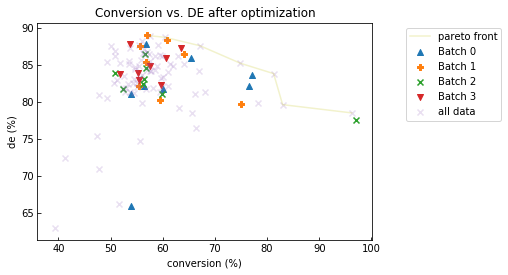

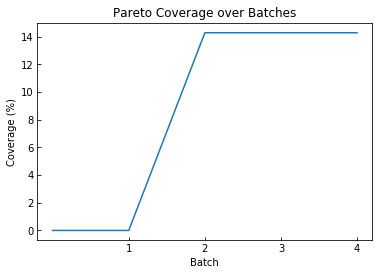

In [103]:
#Visualize the optimizationdata
plt.figure()
ax = plt.subplot(111)
ax.tick_params(direction='in')
markers = ['^', 'P', 'x', 'v', 'p', 'o', 's', '>', 'D', '<', '*']
for i in range(4): 
    data = experiments[experiments['batch']==float(i)].data_to_numpy()
    ax.scatter(data[:, 0], data[:, 1], marker=markers[i],label=f"Batch {i}")
ax.scatter(all_experiments[:, 0], all_experiments[:, 1], marker='x', alpha=0.2, label='all data')
ax.plot(pareto[:, 0], pareto[:, 1], c='y', label='pareto front', alpha=0.2)
ax.legend(bbox_to_anchor=(1.4, 1))
plt.xlabel('conversion (%)'); plt.ylabel('de (%)')
plt.title('Conversion vs. DE after optimization')
plt.savefig('outputs/solvent_optimization_molecular_descriptors.png')
plt.savefig('outputs/solvent_optimization_molecular_descriptors.svg')

coverages = np.zeros(num_batches)
pareto_size = solvents_pareto.shape[0]
for i in range(num_batches):
    batches = experiments[experiments['batch']<= i]
    check = solvents_pareto.index.values.any() == batches['solvent']
    num_covered = np.count_nonzero(check)
    coverages[i] = num_covered/pareto_size*100
#   coverages[i] = pareto_coverage(pareto, batches.data_to_numpy()[:, [0, 1]].astype(np.float64) )
plt.figure()
ax = plt.subplot(111)
ax.tick_params(direction='in')
ax.plot(np.arange(0, num_batches, 1, dtype=int), coverages)
ax.set_xticks(np.arange(1, num_batches, 1, dtype=int),minor=False)
ax.set_xlabel('Batch'); ax.set_ylabel('Coverage (%)')
_ = ax.set_title('Pareto Coverage over Batches')

Though the pareto coverage statistics aren't great, the algorithm does does pick several solvents, which are close to the pareto front.  The one issue is that there is a signficant amount of clustering of the solvents in one area of the output space, so there is a lot of sampling from that region. Finding some way to introduce more randomness (i.e., exploring) might be helpful.

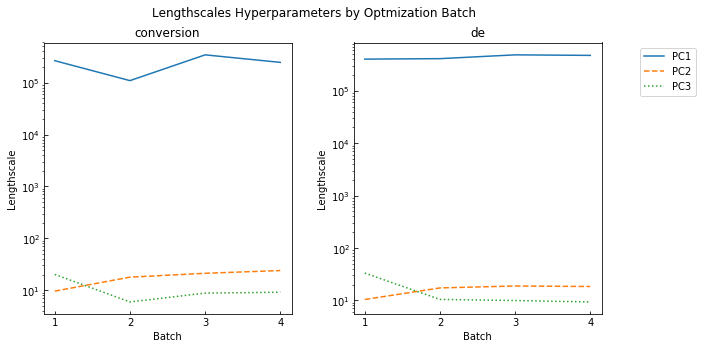

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
linestyles = ['-', '--', ':']
titles = ['conversion', 'de']
for j, ax in enumerate(axes):
    for i in range(num_components):
        ax.plot(np.arange(1, num_batches, 1, dtype=int), lengthscales[:, i, j], 
                   linestyle=linestyles[i], label=f'PC{i+1}')
    ax.set_yscale('log')
    ax.set_ylabel('Lengthscale')
    ax.set_xlabel('Batch')
    ax.set_title(titles[j])
    ax.set_xticks(np.arange(1, num_batches, 1, dtype=int),minor=False)
    ax.tick_params(direction='in')
axes[1].legend(bbox_to_anchor=(1.4, 1))
fig.suptitle('Lengthscales Hyperparameters by Optmization Batch')
plt.savefig('outputs/solvent_optimization_molecular_descriptors_lengthscales.png')
plt.savefig('outputs/solvent_optimization_molecular_descriptors_lengthscales.svg')

The GP model identifies that PC<sub>1</sub> is not relevant. The problem is that PC<sub>1</sub> is usually not relevant except in a special case: when PC<sub>1</sub> is large and PC<sub>2</sub> and PC<sub>3</sub> are small. This sort of intertwined behavior might only be able to be captured by an additive or multiplicative kernel. 

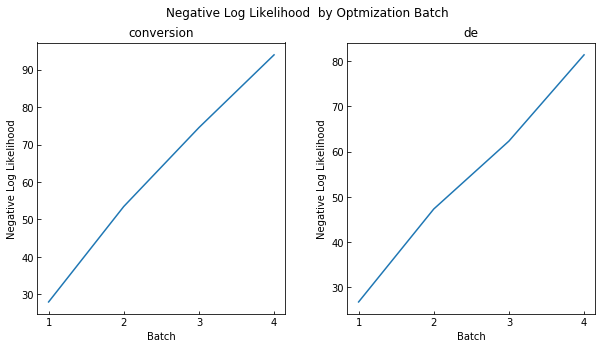

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
linestyles = ['-', '--', ':']
for j, ax in enumerate(axes):
    ax.plot(np.arange(1, num_batches, 1, dtype=int), -log_likelihoods[:,j])
    ax.set_ylabel('Negative Log Likelihood')
    ax.set_xlabel('Batch')
    ax.set_title(titles[j])
    ax.set_xticks(np.arange(1, num_batches, 1, dtype=int),minor=False)
    ax.tick_params(direction='in')
fig.suptitle('Negative Log Likelihood  by Optmization Batch')
plt.savefig('outputs/solvent_optimization_molecular_descriptors_log_likelihood.png')
plt.savefig('outputs/solvent_optimization_molecular_descriptors_log_likelihood.svg')

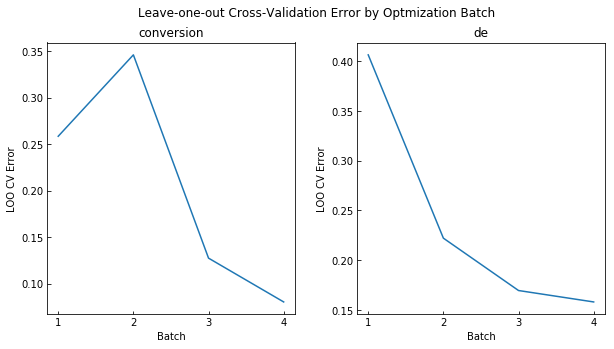

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(hspace=0.2, wspace=0.25)
linestyles = ['-', '--', ':']
for j, ax in enumerate(axes):
    ax.plot(np.arange(1, num_batches, 1, dtype=int), loo_errors[:,j])
    ax.set_ylabel('LOO CV Error')
    ax.set_xlabel('Batch')
    ax.set_title(titles[j])
    ax.set_xticks(np.arange(1, num_batches, 1, dtype=int),minor=False)
    ax.tick_params(direction='in')
fig.suptitle('Leave-one-out Cross-Validation Error by Optmization Batch')
plt.savefig('outputs/solvent_optimization_molecular_descriptors_loo_cv.png')
plt.savefig('outputs/solvent_optimization_molecular_descriptors_loo_cv.svg')